# Datenaufbereitung

Als erstes werden notwendige <span style="color:seagreen">packages</span> installiert und <span style="color:coral">csv</span> Dateien von Netflix und Disney+ eingelesen und in <span style="color:lightblue">df_list</span> gespeichert für eine schnellere Datenbereinigung und weniger Codezeilen und für das Zusammenführen.

# Inhaltsverzeichnis

- [Cleaning](#cleaning)  : [Für Beide](##für-beide) & [Netflix](##netflix) & [Disney+](##disney)
- [Speichern](#1.-speichern)
- [Zusammenführen und Speichern](#zusammenführen-und-speichern)

In [119]:
import pandas as pd
import numpy as np
import os
import plotly as pl
import pycountry
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import scipy.sparse as sp

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
dataset_dir = os.path.join(notebook_dir, '../1_Datenset/ursprüngliche')

disney_df = pd.read_csv(os.path.join(dataset_dir, 'disney_plus_titles.csv'), sep=',')
netflix_df = pd.read_csv(os.path.join(dataset_dir, 'netflix_titles.csv'), sep=',')

df_list = [
    ('disney_df', disney_df),
    ('netflix_df', netflix_df)
]

## Cleaning



### Für Beide

1. Leere Zellen in der Spalte: Director, ersetzten mit: unknown
2. Leere Zellen in der Spalte: Cast, ersetzten mit: unknown
3. Leere Zellen in der Spalte: Country, ersetzten mit: unknown

In [120]:
print('Nullwerte pro Spalte: ')
for name, df in df_list:
    df['director'] = df['director'].fillna('unknown')
    df['cast'] = df['cast'].fillna('unknown')
    df['country'] = df['country'].fillna('unknown')

    print(name)
    print(df.isna().sum())

Nullwerte pro Spalte: 
disney_df
show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      3
release_year    0
rating          3
duration        0
listed_in       0
description     0
dtype: int64
netflix_df
show_id          0
type             0
title            0
director         0
cast             0
country          0
date_added      10
release_year     0
rating           4
duration         3
listed_in        0
description      0
dtype: int64


4. Spalten die nicht benötigt werden löschen: date_added, release_year

In [121]:
for name, df in df_list:  
    df.drop(columns=['date_added', 'release_year'], inplace=True)
    


1. Länder anschauen 
    - wieso gibt es so viele?
    - sind sie plausibel? -> wenn nicht dann korrigieren

-> 'United States, Ghana, Burkina Faso, United Kingdom, Germany, Ethiopia' das hier wird als ein Land gewertet, welche falsch ist

#### Netflix


In [122]:
netflix_df['country'].unique()


array(['United States', 'South Africa', 'unknown', 'India',
       'United States, Ghana, Burkina Faso, United Kingdom, Germany, Ethiopia',
       'United Kingdom', 'Germany, Czech Republic', 'Mexico', 'Turkey',
       'Australia', 'United States, India, France', 'Finland',
       'China, Canada, United States',
       'South Africa, United States, Japan', 'Nigeria', 'Japan',
       'Spain, United States', 'France', 'Belgium',
       'United Kingdom, United States', 'United States, United Kingdom',
       'France, United States', 'South Korea', 'Spain',
       'United States, Singapore', 'United Kingdom, Australia, France',
       'United Kingdom, Australia, France, United States',
       'United States, Canada', 'Germany, United States',
       'South Africa, United States', 'United States, Mexico',
       'United States, Italy, France, Japan',
       'United States, Italy, Romania, United Kingdom',
       'Australia, United States', 'Argentina, Venezuela',
       'United States, Unit

In [123]:
netflix_df_copy = netflix_df.copy()
netflix_df_copy['country'] = netflix_df_copy['country'].str.split(',')
netflix_df_copy['country'] = netflix_df_copy['country'].apply(lambda x: [country.strip() for country in x])
netflix_df_countries = netflix_df_copy.explode('country')
netflix_movies_per_country = netflix_df_countries['country'].value_counts()
print(netflix_movies_per_country) 
 

country
United States     3690
India             1046
unknown            831
United Kingdom     806
Canada             445
                  ... 
Sudan                1
Panama               1
Uganda               1
East Germany         1
Montenegro           1
Name: count, Length: 124, dtype: int64


In [124]:
netflix_df_copy_2 = netflix_df.copy()
netflix_df_copy_2['director'] = netflix_df_copy_2['director'].str.split(',')
netflix_df_copy_2['director'] = netflix_df_copy_2['director'].apply(lambda x: [director.strip() for director in x])
netflix_df_director = netflix_df_copy_2.explode('director')
netflix_movies_per_director = netflix_df_director['director'].value_counts()
print(netflix_movies_per_director)

director
unknown                    2634
Rajiv Chilaka                22
Jan Suter                    21
Raúl Campos                  19
Suhas Kadav                  16
                           ... 
Mu Chu                        1
Chandra Prakash Dwivedi       1
Majid Al Ansari               1
Peter Hewitt                  1
Mozez Singh                   1
Name: count, Length: 4994, dtype: int64


In [125]:
def is_valid_country(country_name):
    if pd.isna(country_name) or country_name.lower() in ['unknown'] + ['russia']:
        return True
    try:
        pycountry.countries.lookup(country_name)
        return True
    except LookupError:
        return False

def is_valid_country(country_name):
    valid_countries = ['turkey', 'russia', 'palestine', 'vatican city', 'soviet union']
    if pd.isna(country_name) or country_name.lower() in ['unknown'] + valid_countries:
        return True
    if country_name.lower() == 'soviet union':
        country_name = 'russia'
    if country_name.lower() in ['west germany', 'east germany']:
        country_name = 'germany'
    try:
        pycountry.countries.lookup(country_name)
        return True
    except LookupError:
        return False


invalid_countries = netflix_df['country'].apply(lambda x: [country.strip() for country in str(x).split(',') if country.strip() != 'unknown' and not is_valid_country(country.strip())])
print('Nicht plasible Länder')

print(invalid_countries[invalid_countries.apply(len) > 0])



Nicht plasible Länder
193     []
365     []
1192    []
2224    []
4653    []
5925    []
7007    []
Name: country, dtype: object


In [126]:
print(netflix_df.loc[193, ['show_id', 'title', 'country']])
print('--------------------------------------------------------------------')
print(netflix_df.loc[365, ['show_id', 'title', 'country']])
print('--------------------------------------------------------------------')
print(netflix_df.loc[1192, ['show_id', 'title', 'country']])
print('--------------------------------------------------------------------')
print(netflix_df.loc[2224, ['show_id', 'title', 'country']])
print('--------------------------------------------------------------------')
print(netflix_df.loc[4653, ['show_id', 'title', 'country']])
print('--------------------------------------------------------------------')
print(netflix_df.loc[5925, ['show_id', 'title', 'country']])
print('--------------------------------------------------------------------')
print(netflix_df.loc[7007, ['show_id', 'title', 'country']])

show_id             s194
title               D.P.
country    , South Korea
Name: 193, dtype: object
--------------------------------------------------------------------
show_id                 s366
title        Eyes of a Thief
country    , France, Algeria
Name: 365, dtype: object
--------------------------------------------------------------------
show_id              s1193
title          The Present
country    United Kingdom,
Name: 1192, dtype: object
--------------------------------------------------------------------
show_id                                     s2225
title                                       Funan
country    France, Belgium, Luxembourg, Cambodia,
Name: 2224, dtype: object
--------------------------------------------------------------------
show_id             s4654
title         City of Joy
country    United States,
Name: 4653, dtype: object
--------------------------------------------------------------------
show_id              s5926
title              Virunga
co

In [127]:
#Länder umändern, sie pausible machen
netflix_df.loc[365, 'country'] = netflix_df.loc[365, 'country'].replace(', France, Algeria', 'France, Algeria')
netflix_df.loc[4653,'country'] = netflix_df.loc[4563, 'country'].replace('United States,', 'United States')
netflix_df.loc[5925, 'country'] = netflix_df.loc[5925, 'country'].replace('United Kingdom,', 'United Kingdom')
netflix_df.loc[7007, 'country'] = netflix_df.loc[7007, 'country'].replace('Poland,', 'Poland')
netflix_df.loc[1192, 'country'] = 'France, Belgium, Luxembourg, Cambodia'
netflix_df.loc[193, 'country'] = netflix_df.loc[193, 'country'].replace(', South Korea', 'South Korea')
netflix_df.loc[2224,'country'] = 'United States'

In [128]:
invalid_countries = netflix_df['country'].apply(lambda x: [country.strip() for country in str(x).split(',') if country.strip() != 'unknown' and not is_valid_country(country.strip())])
print('Nicht plasible Länder:')
if len(invalid_countries[invalid_countries.apply(len) > 0]) == 0:
    print('Alle Länder sind plausibel')
else:
    print(invalid_countries[invalid_countries.apply(len) > 0])


Nicht plasible Länder:
Alle Länder sind plausibel


#### Disney+

##### Länder

In [129]:
disney_df['country'].unique()

array(['unknown', 'United States', 'United States, Canada',
       'United States, Australia', 'Canada',
       'United States, United Kingdom', 'United States, South Korea',
       'Ireland, United States, Canada, United Kingdom, Denmark, Spain, Poland, Hungary',
       'France, United Kingdom', 'United Kingdom, Australia',
       'Ireland, United States', 'Canada, United States, France',
       'France, South Korea, Japan, United States', 'France',
       'United States, United Kingdom, Hungary', 'United States, Germany',
       'United States, United Kingdom, Australia', 'United States, India',
       'United States, Canada, United Kingdom, Singapore, Australia, Thailand',
       'Canada, United States',
       'South Korea, United States, China, Japan',
       'Australia, United Kingdom', 'United Kingdom',
       'United States, United Kingdom, South Korea',
       'United States, United Kingdom, Canada',
       'United States, Germany, United Kingdom',
       'United States, Canad

In [130]:
disney_df_copy = disney_df.copy()
disney_df_copy['country'] = disney_df_copy['country'].str.split(',')
disney_df_copy['country'] = disney_df_copy['country'].apply(lambda x: [country.strip() for country in x])
disney_df_countries = disney_df_copy.explode('country')
disney_movies_per_country = disney_df_countries['country'].value_counts()
print(disney_movies_per_country)

country
United States           1184
unknown                  219
United Kingdom           101
Canada                    77
Australia                 23
France                    22
South Korea               13
Japan                     10
China                     10
Germany                    9
Ireland                    8
Taiwan                     6
India                      5
Mexico                     4
Hong Kong                  4
Spain                      4
South Africa               3
Argentina                  3
Hungary                    3
Denmark                    3
New Zealand                3
Poland                     2
Singapore                  2
Austria                    2
Philippines                2
United Arab Emirates       2
Malaysia                   2
Brazil                     1
Switzerland                1
Tanzania                   1
Belgium                    1
Thailand                   1
Angola                     1
Panama                     1
Luxemb

In [131]:
disney_df_copy_2 = disney_df.copy()
disney_df_copy_2['director'] = disney_df_copy_2['director'].str.split(',')
disney_df_copy_2['director'] = disney_df_copy_2['director'].apply(lambda x: [director.strip() for director in x])
disney_df_director = disney_df_copy_2.explode('director')
disney_movies_per_director = disney_df_director['director'].value_counts()
print(disney_movies_per_director)

director
unknown             473
Jack Hannah          17
Wilfred Jackson      16
John Lasseter        16
Paul Hoen            16
                   ... 
Zhong Yu              1
Byron Haskin          1
Steven Lisberger      1
Jay Russell           1
Nick Castle           1
Name: count, Length: 636, dtype: int64


In [132]:
d_invalid_countries = disney_df['country'].apply(lambda x: [country.strip() for country in str(x).split(',') if country.strip() != 'unknown' and not is_valid_country(country.strip())])

print('Nicht plasible Länder')
if len(d_invalid_countries[d_invalid_countries.apply(len) > 0]) == 0:
    print('Alle Länder sind plausibel')
else:
    print(d_invalid_countries[d_invalid_countries.apply(len) > 0])


Nicht plasible Länder
Alle Länder sind plausibel


## 1. Speichern 

In [133]:
netflix_df.to_csv('../1_Datenset/erstellte/cleaned/netflix_titles_cleaned.csv', index=False)

disney_df.to_csv('../1_Datenset/erstellte/cleaned/disney_plus_titles_cleaned.csv', index=False)

## Zusammenführen und Speichern

Hier werden die 2 Datensätze zusammengeführt zu eine einzige Datensatz, dabei werden die Platforme (Netflix und Disney+) in eine extra Spalte gespeichert.

In [134]:
# Pfade zu den CSV-Dateien
netflix_cleaned_file = '../1_Datenset/erstellte/cleaned/netflix_titles_cleaned.csv'
disney_cleaned_file = '../1_Datenset/erstellte/cleaned/disney_plus_titles_cleaned.csv'

# Lade die Netflix CSV-Datei und füge eine Spalte für die Plattform hinzu
netflix_cleaned_df = pd.read_csv(netflix_cleaned_file)
netflix_cleaned_df['platform'] = 'Netflix'

# Lade die Disney+ CSV-Datei und füge eine Spalte für die Plattform hinzu
disney_cleaned_df = pd.read_csv(disney_cleaned_file)
disney_cleaned_df['platform'] = 'Disney+'

# Finde gemeinsame Titel
common_titles_cleaned = set(netflix_cleaned_df['title']).intersection(set(disney_cleaned_df['title']))

# Markiere gemeinsame Titel in beiden DataFrames
netflix_cleaned_df['platform'] = netflix_cleaned_df.apply(lambda row: 'Netflix, Disney+' if row['title'] in common_titles_cleaned else 'Netflix', axis=1)
disney_cleaned_df['platform'] = disney_cleaned_df.apply(lambda row: 'Netflix, Disney+' if row['title'] in common_titles_cleaned else 'Disney+', axis=1)

# Kombiniere die DataFrames
df = pd.concat([netflix_cleaned_df, disney_cleaned_df], ignore_index=True)

#Entferne doppelte Einträge
df = df.drop_duplicates(subset=['title'])

# Benenne die Spalte 'rating' in 'agerating' um
df.rename(columns={'rating': 'agerating'}, inplace=True)

# Gruppiere nach allen Spalten außer 'platform' und kombiniere die Plattformen
df = df.groupby(['show_id', 'type', 'title', 'director', 'cast', 'country', 'agerating', 'duration', 'listed_in', 'description'], as_index=False).agg({'platform': lambda x: ', '.join(sorted(set(x)))})

# Neuverteilung der show_id von oben nach unten in der Form 's1', 's2', ...
df['show_id'] = ['s' + str(i+1) for i in range(len(df))]

# Gib das kombinierte DataFrame aus
print(df.head())

# Speichere das kombinierte DataFrame in einer neuen CSV-Datei
df.to_csv('../1_Datenset/erstellte/fertig/shows.csv', index=False)


  show_id   type                                             title  \
0      s1  Movie                              Dick Johnson Is Dead   
1      s2  Movie  Duck the Halls: A Mickey Mouse Christmas Special   
2      s3  Movie             A Muppets Christmas: Letters To Santa   
3      s4  Movie                                      The Starling   
4      s5  Movie                       Confessions of a Shopaholic   

                            director  \
0                    Kirsten Johnson   
1  Alonso Ramirez Ramos, Dave Wasson   
2                   Kirk R. Thatcher   
3                     Theodore Melfi   
4                         P.J. Hogan   

                                                cast        country agerating  \
0                                            unknown  United States     PG-13   
1  Chris Diamantopoulos, Tony Anselmo, Tress MacN...        unknown      TV-G   
2  Steve Whitmire, Dave Goelz, Bill Barretta, Eri...  United States         G   
3  Melissa McC

In [135]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10204 entries, 0 to 10203
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   show_id      10204 non-null  object
 1   type         10204 non-null  object
 2   title        10204 non-null  object
 3   director     10204 non-null  object
 4   cast         10204 non-null  object
 5   country      10204 non-null  object
 6   agerating    10204 non-null  object
 7   duration     10204 non-null  object
 8   listed_in    10204 non-null  object
 9   description  10204 non-null  object
 10  platform     10204 non-null  object
dtypes: object(11)
memory usage: 877.0+ KB
None


In [136]:
# Zeige die eindeutigen Werte in der Spalte 'platform'
unique_platforms = df['platform'].unique()
print(f"Einzigartige Werte in der Spalte 'platform': {unique_platforms}")

# Zähle die Anzahl der Einträge für jede Plattform
cleaned_netflix_count = df[df['platform'] == 'Netflix'].shape[0]
cleaned_disney_count = df[df['platform'] == 'Disney+'].shape[0]
cleaned_both_count = df[df['platform'] == 'Netflix, Disney+'].shape[0]

print(f"Anzahl der Netflix-Einträge: {cleaned_netflix_count}")
print(f"Anzahl der Disney+-Einträge: {cleaned_disney_count}")
print(f"Anzahl der Einträge auf beiden Plattformen: {cleaned_both_count}")


Einzigartige Werte in der Spalte 'platform': ['Netflix' 'Disney+' 'Netflix, Disney+']
Anzahl der Netflix-Einträge: 8757
Anzahl der Disney+-Einträge: 1404
Anzahl der Einträge auf beiden Plattformen: 43


## Genres vereinfachen 

zu viele vorhanden oder zum beispiel nur andere schriftweise: 'Action & Adventure' = 'Action-Adventure'

In [137]:
df = pd.read_csv("../1_Datenset/erstellte/fertig/shows.csv")
df_copy = df.copy()
df_copy['listed_in'] = df_copy['listed_in'].str.split(',')
df_copy['listed_in'] = df_copy['listed_in'].apply(lambda x: [genre.strip() for genre in x])
df_genres = df_copy.explode('listed_in')
df_genres['listed_in'] = df_genres['listed_in'].str.strip()
all_genres = df_genres['listed_in'].unique()
print(all_genres)
anzahl_genres = len(all_genres)
print(f"Anzahl der einzigartigen Genres: {anzahl_genres}")

['Documentaries' 'Animation' 'Family' 'Comedy' 'Musical' 'Comedies'
 'Dramas' 'Romance' 'Romantic Comedy' 'TV Comedies' 'TV Dramas'
 'International Movies' 'Thrillers' 'Action & Adventure'
 'Action-Adventure' 'International TV Shows' "Kids' TV"
 'Children & Family Movies' 'Fantasy' 'Coming of Age' 'Drama' 'Music'
 'Spanish-Language TV Shows' 'Kids' 'Animals & Nature' 'Buddy'
 'Music & Musicals' 'Concert Film' 'Sports Movies' 'Dance'
 'Independent Movies' 'Docuseries' 'Historical' 'Anime Series'
 'Horror Movies' 'Romantic Movies' 'Sci-Fi & Fantasy' 'Documentary'
 'Science & Nature TV' 'Stand-Up Comedy & Talk Shows' 'Superhero'
 'Science Fiction' 'Romantic TV Shows' 'Crime TV Shows' 'Anime Features'
 'TV Thrillers' 'Reality TV' 'Korean TV Shows' 'British TV Shows'
 'LGBTQ Movies' 'Spy/Espionage' 'Cult Movies' 'TV Horror' 'TV Mysteries'
 'Teen TV Shows' 'Anthology' 'Variety' 'Biographical' 'Sports' 'Mystery'
 'Thriller' 'Faith & Spirituality' 'Classic Movies' 'Stand-Up Comedy'
 'Crime' 'T

In [138]:
def rewrite_genres(genres):
    rewritten_genres = []
    for genre in genres:
        if genre in ['Action-Adventure', 'TV Action & Adventure', 'Superhero', 'Survival', 'Spy/Espionage']:
            rewritten_genres.append('Action & Adventure')
        elif genre in ['Documentaries', 'Docuseries']:
            rewritten_genres.append('Documentary')
        elif genre in ['Dramas', 'TV Dramas', 'Soap Opera / Melodrama']:
            rewritten_genres.append('Drama')    
        elif genre in ['Disaster', 'Crime', 'Mystery', 'TV Mysteries', 'TV Thrillers', 'Police/Cop', 'Crime TV Shows', 'Thrillers', 'Thriller']:
            rewritten_genres.append('Thriller & Krimi')
        elif genre in ['Comedies', 'TV Comedies', 'Stand-Up Comedy', 'Parody', 'Talk Show', 'Stand-Up Comedy & Talk Shows', 'Buddy']:
            rewritten_genres.append('Comedy')
        elif genre in ['Romantic Comedy', 'Romantic Movies', 'Romantic TV Shows']:
            rewritten_genres.append('Romance')
        elif genre in ['Music', 'Musical', 'Dance', 'Concert Film']:
            rewritten_genres.append('Music & Musicals')
        elif genre in ['Anime Series', 'Anime Features', 'Anime']:
            rewritten_genres.append('Animation')
        elif genre in ['Animals & Nature', 'Travel', 'Medical', 'Science & Nature TV']:
            rewritten_genres.append('Science & Nature')
        elif genre in ['Fantasy', 'Science Fiction', 'TV Sci-Fi & Fantasy']:
            rewritten_genres.append('Sci-Fi & Fantasy')
        elif genre in ['Kids', 'Family', 'Children & Family Movies', "Kids' TV"]:
            rewritten_genres.append('Children & Family')
        elif genre in ['Classic Movies', 'Classic & Cult TV', 'Cult Movies']:
            rewritten_genres.append('Classic')
        elif genre in ['Teen TV Shows', 'Coming of Age', 'LQBTQ Movies', 'Teen']:
            rewritten_genres.append('Teen & Coming of Age')
        elif genre in ['Biographical']:
            rewritten_genres.append('Historical')
        elif genre in ['TV Horror', 'Horror Movies']:
            rewritten_genres.append('Horror')
        elif genre in ['Sports Movies', 'Sports']:
            rewritten_genres.append('Sport')
        elif genre in ['British TV Shows', 'Spanish-Language TV Shows', 'Korean TV Shows', 'International Movies', 'International TV Shows']:
            rewritten_genres.append('International')
        elif genre in ['Reality TV']:
            rewritten_genres.append('Reality')
        elif genre in ['Independent Movies']:
            rewritten_genres.append('Independent')
        elif genre in ['Anthology', 'Variety', 'Game Show / Competition']:
            rewritten_genres.append('Entertainment')
        elif genre in ['Faith & Spirituality', 'Lifestyle']:
            rewritten_genres.append('Lifestyle')
        elif genre in ['TV Shows']:
            rewritten_genres.append('Series')
        else:
            rewritten_genres.append(genre)
    unique_genres = list(set(rewritten_genres))
    return ', '.join(unique_genres)

In [139]:
# Umschreibung für Gruppierung
df['listed_in'] = df['listed_in'].str.split(', ').apply(rewrite_genres)
df_genre2 = df['listed_in'].str.split(', ', expand=True).stack()
unique_genres = df_genre2.unique()
print("Namen der Genres:", unique_genres)
unique_genres = len(unique_genres)
print(f"Anzahl der einzigartigen Genres: {unique_genres}")
df_genre_counts2 = df_genre2.value_counts()
# Ausgabe der Anzahl von Genres
print("Anzahl der Genres:")
print(df_genre_counts2)

Namen der Genres: ['Documentary' 'Children & Family' 'Animation' 'Music & Musicals' 'Comedy'
 'Drama' 'Romance' 'Thriller & Krimi' 'International' 'Action & Adventure'
 'Sci-Fi & Fantasy' 'Teen & Coming of Age' 'Science & Nature' 'Sport'
 'Independent' 'Historical' 'Horror' 'Reality' 'LGBTQ Movies' 'Classic'
 'Entertainment' 'Lifestyle' 'Series' 'Western' 'Movies']
Anzahl der einzigartigen Genres: 25
Anzahl der Genres:
International           4268
Drama                   3319
Comedy                  3157
Children & Family       1816
Documentary             1551
Action & Adventure      1464
Thriller & Krimi        1190
Romance                 1007
Animation                774
Independent              756
Sci-Fi & Fantasy         590
Music & Musicals         466
Horror                   432
Science & Nature         301
Reality                  281
Teen & Coming of Age     268
Sport                    261
Classic                  202
LGBTQ Movies             102
Historical                

## Vektorisierung

Dabei werden die Textdaten vorberetiet und in nummerische Werte umgewandelt.

1. TF-IDF Vektorisierung: titel, desciption, director, cast, listed_in
    - Nutze TfidfVectorizer aus sklearn.feature_extraction.text.
    - Entferne Stoppwörter (stop_words="english"), um irrelevante Wörter auszuschließen.
    - Begrenze die Anzahl der Features (max_features=5000), um Rechenleistung zu sparen.
    - Wende es auf eine kombinierte Textspalte an (title + description + director + cast + listed_in).


In [140]:
df["combined_text"] = df["title"] + " " + df["description"] + " " + df["director"] + " " + df["cast"] 
tfidf = TfidfVectorizer(stop_words="english", max_features=10000000)
tfidf_matrix = tfidf.fit_transform(df["combined_text"])


2. Nummerische Features bereinigen

-> Länge in Zahlformat umschreiben
- für Serien nehmen wir dne durchshcnittlichen 45 Minuten für eine Folge da wir nicht wissen wie viele Folgen eine Spalte hat.

In [141]:
def extract_duration(duration):
    """Extrahiert die Dauer in Minuten aus dem Text."""
    match = re.search(r"(\d+)", str(duration))
    if match:
        return int(match.group(1))
    return None  # Falls keine Zahl gefunden wird

df["duration_minutes"] = df["duration"].apply(extract_duration)

# Falls "Seasons" in der Dauer steht, eine Standardlänge annehmen (z. B. 45 Min. pro Episode)
df.loc[df["duration"].str.contains("Season", na=False), "duration_minutes"] = 45

# Fehlende Werte mit Median füllen
df["duration_scaled"] = df["duration_minutes"].fillna(df["duration_minutes"].median())

3. kategorische Daten kodieren

Einige Features sind kategorisch, müssen aber als Zahlen vorliegen:

- Altersfreigabe (agerating) → LabelEncoder


In [142]:
label_encoder = LabelEncoder()
df["agerating_encoded"] = label_encoder.fit_transform(df["agerating"])

'''
def convert_agerating(agerating):
    """Konvertiert Altersfreigaben in eine numerische Skala."""
    agerating_map = {
        "G": 0, "TV-Y": 0, "TV-G": 0,
        "PG": 10, "TV-Y7": 7, "TV-Y7-FV": 7, "TV-PG": 10,
        "PG-13": 13,
        "R": 17, "TV-14": 14,
        "NC-17": 18, "TV-MA": 17,
        "NR": -1, "UR": -1
    }
    if pd.isna(agerating) or agerating == "":
        return -1  # Falls das Rating fehlt, setze -1
    return agerating_map.get(agerating, -1)  # Falls unbekannt, setze -1


df["agerating_numeric"] = df["agerating"].apply(convert_agerating)
'''

'\ndef convert_agerating(agerating):\n    """Konvertiert Altersfreigaben in eine numerische Skala."""\n    agerating_map = {\n        "G": 0, "TV-Y": 0, "TV-G": 0,\n        "PG": 10, "TV-Y7": 7, "TV-Y7-FV": 7, "TV-PG": 10,\n        "PG-13": 13,\n        "R": 17, "TV-14": 14,\n        "NC-17": 18, "TV-MA": 17,\n        "NR": -1, "UR": -1\n    }\n    if pd.isna(agerating) or agerating == "":\n        return -1  # Falls das Rating fehlt, setze -1\n    return agerating_map.get(agerating, -1)  # Falls unbekannt, setze -1\n\n\ndf["agerating_numeric"] = df["agerating"].apply(convert_agerating)\n'

nomalizierung der numerical spalten

In [143]:
# MinMaxScaler für Normalisierung
scaler = MinMaxScaler()

# Altersfreigabe & Dauer normalisieren
df[["agerating_scaled", "duration_scaled"]] = scaler.fit_transform(df[["agerating_encoded", "duration_minutes"]])
print(df[["agerating_scaled", "duration_scaled"]])

       agerating_scaled  duration_scaled
0              0.307692         0.286174
1              0.538462         0.070740
2              0.000000         0.141479
3              0.307692         0.331190
4              0.230769         0.337621
...                 ...              ...
10199          0.000000         0.019293
10200          0.846154         0.141479
10201          0.692308         0.141479
10202          0.230769         0.353698
10203          0.461538         0.183280

[10204 rows x 2 columns]


4. Multi-Label-Binarizer (MLB) nutzen, um Genres als binäre Features zu kodieren

genau das auch bei platform

In [144]:
# Genres in Listen umwandeln
df["genre_list"] = df["listed_in"].apply(lambda x: x.split(", "))

# Multi-Label Binarizer (One-Hot-Encoding für mehrere Kategorien)
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df["genre_list"])

# Genre-Feature-Namen holen
genre_labels = mlb.classes_

# DataFrame mit Genres als Spalten erstellen
df_genres = pd.DataFrame(genre_encoded, columns=genre_labels)

# Genres zu Haupt-Datenframe hinzufügen
df = pd.concat([df, df_genres], axis=1)


In [145]:
# Plattformen in Listen umwandeln
df["platform_list"] = df["platform"].apply(lambda x: x.split(", "))

# Multi-Label Binarizer für Plattformen
mlb_platform = MultiLabelBinarizer()
platform_encoded = mlb_platform.fit_transform(df["platform_list"])

# DataFrame mit Plattform-Spalten erstellen
df_platforms = pd.DataFrame(platform_encoded, columns=mlb_platform.classes_)

# Plattform-Daten zum Haupt-Datenframe hinzufügen
df = pd.concat([df, df_platforms], axis=1)

6. Cosine Similarity

In [146]:
similarity_matrix = cosine_similarity(tfidf_matrix)


7. Feature-Matrix zusammensetzten

- Textfeatures (TF-IDF)
- Kategorische Features (Altersfreigabe, Plattform)
- Numerische Features (Dauer, ggf. andere)
- Gewichtete Kombination für bessere Empfehlungen


In [147]:

# Kombination aller Features
feature_matrix = sp.hstack([
    tfidf_matrix,  # Textdaten (TF-IDF)
    df[["agerating_scaled", "duration_scaled"]].values,  # Altersfreigabe & Dauer
    df_genres.values,  # Genre-One-Hot
    df_platforms.values  # Plattform-One-Hot
])


In [148]:

# Speichere das kombinierte DataFrame in einer neuen CSV-Datei
df.to_csv('../1_Datenset/erstellte/fertig/shows.csv', index=False)


In [149]:

# Cosine Similarity zwischen allen Filmen berechnen
similarity_matrix = cosine_similarity(feature_matrix, feature_matrix)


In [150]:


def get_recommendations(title, df, similarity_matrix, top_n=5):
    # Index des Films holen
    idx = df[df["title"] == title].index[0]
    
    # Ähnlichkeiten für den ausgewählten Film holen
    sim_scores = list(enumerate(similarity_matrix[idx]))
    
    # Filme nach Ähnlichkeit sortieren (höchste zuerst)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Top-N Filme holen (ohne den ersten, weil das der gleiche Film ist)
    sim_scores = sim_scores[1:top_n+1]
    
    # Film-Indizes extrahieren
    movie_indices = [i[0] for i in sim_scores]
    
    # Empfohlene Filme ausgeben
    return df.iloc[movie_indices][["title", "listed_in", "platform_list"]]


In [151]:
print(get_recommendations("The Starling", df, similarity_matrix, top_n=10))


                                title      listed_in platform_list
6321                     Mother's Day  Drama, Comedy     [Netflix]
9562                    THE RUM DIARY  Drama, Comedy     [Netflix]
4456                Maps to the Stars  Drama, Comedy     [Netflix]
3337              Dolemite Is My Name  Drama, Comedy     [Netflix]
3384                   The Laundromat  Drama, Comedy     [Netflix]
7923                    Julie & Julia  Drama, Comedy     [Netflix]
9511  The Perks of Being a Wallflower  Drama, Comedy     [Netflix]
738                          War Dogs  Drama, Comedy     [Netflix]
3016                 Private Practice  Drama, Comedy     [Netflix]
3528            The Edge of Seventeen  Drama, Comedy     [Netflix]



ist split sinnvol??

es gibt bei Empfehlungssystemen einen kleinen Unterschied zu klassischen ML-Modellen:

Wir haben keine klassische Zielvariable (y) → Stattdessen nutzen wir Ähnlichkeitsmessungen.
Das bedeutet, dass ein normaler train_test_split nicht immer sinnvoll ist.

1. Train-Test-Split mit Scikit-Learn

Falls du trotzdem eine klassische Aufteilung möchtest:
Hier teilen wir das Feature-Set in 70% Training, 15% Validierung, 15% Test.

2. Alternativer Ansatz: Leave-One-Out-Cross-Validation (LOOCV)

Da wir Filme basierend auf Ähnlichkeit empfehlen, ist eine Leave-One-Out-Validierung (LOOCV) oft besser.
LOOCV simuliert echte Empfehlungen:
Nimmt einen Film als "Test"
Überprüft, ob ähnliche Filme richtig empfohlen wurden

# Anlass mit unsupervised Learning

    1. Problemdefinition: "Anlass" als Kategorie
        - Der Anlass (z. B. "Familienabend", "Party", "Date Night", "Allein Entspannen") kann als Zielvariable (y) genutzt werden.
        - Unser Modell kann dann lernen, basierend auf Dauer, Genre, Altersfreigabe & Beschreibung vorherzusagen, welcher Anlass am besten passt.

    2. Datenset für ML vorbereiten
        - Falls wir keine gelabelten Daten haben, können wir Clustering (K-Means) nutzen, um automatisch ähnliche Gruppen zu finden.
        🔹 Ergebnis: Jeder Film erhält eine automatisch generierte Anlass-Kategorie (anlass_cluster).

In [154]:
from sklearn.cluster import KMeans

# Feature-Matrix für Clustering (Numerische & One-Hot-Encoded Features)
X_cluster = df[["duration_scaled", "agerating_scaled"] + list(df_genres.columns)]

# Anzahl der Cluster (Anlässe) definieren - z. B. 5 verschiedene Kategorien
num_clusters = 5

# KMeans-Clustering anwenden
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df["anlass_cluster"] = kmeans.fit_predict(X_cluster)

# Cluster anzeigen
print(df[["title", "anlass_cluster"]].head(10))



                                              title  anlass_cluster
0                              Dick Johnson Is Dead               3
1  Duck the Halls: A Mickey Mouse Christmas Special               2
2             A Muppets Christmas: Letters To Santa               1
3                                      The Starling               1
4                       Confessions of a Shopaholic               1
5                                      On the Verge               1
6                                              Lava               2
7                                          Stowaway               4
8                                          Wild Dog               4
9      LEGO Disney Frozen: Northern Lights (Shorts)               1


 3. Cluster analysieren & benennen

 Da K-Means nur Zahlen (0-4) für die Cluster zurückgibt, müssen wir analysieren, welche Filme in welchen Gruppen sind, und ihnen passende Namen geben

In [155]:
# Durchschnittswerte je Cluster ansehen
cluster_means = df.groupby("anlass_cluster")[["duration_minutes", "agerating_encoded"]].mean()
print(cluster_means)


                duration_minutes  agerating_encoded
anlass_cluster                                     
0                      87.222294           6.168814
1                      81.205682           6.685227
2                      65.725134           6.995296
3                      67.324482           7.266839
4                      90.153356           7.117450


In [156]:
cluster_mapping = {
    0: "Familienabend",
    1: "Langer Filmabend",
    2: "Date Night",
    3: "Gruselabend",
    4: "Action/Party"
}

df["anlass"] = df["anlass_cluster"].map(cluster_mapping)

print(df[["title", "anlass"]].head(10))


                                              title            anlass
0                              Dick Johnson Is Dead       Gruselabend
1  Duck the Halls: A Mickey Mouse Christmas Special        Date Night
2             A Muppets Christmas: Letters To Santa  Langer Filmabend
3                                      The Starling  Langer Filmabend
4                       Confessions of a Shopaholic  Langer Filmabend
5                                      On the Verge  Langer Filmabend
6                                              Lava        Date Night
7                                          Stowaway      Action/Party
8                                          Wild Dog      Action/Party
9      LEGO Disney Frozen: Northern Lights (Shorts)  Langer Filmabend


4. Optional: Visualisierung der Cluster

Falls du dir die Cluster anschauen willst, kannst du mit t-SNE eine 2D-Darstellung der Cluster erzeugen:

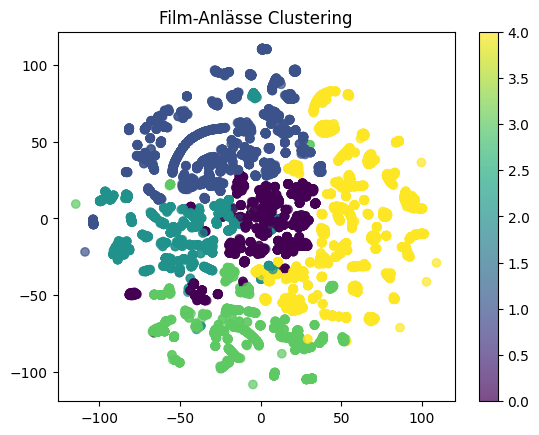

In [157]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# t-SNE Reduktion auf 2D für Visualisierung
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_cluster)

# Scatterplot der Cluster
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=df["anlass_cluster"], cmap="viridis", alpha=0.7)
plt.colorbar()
plt.title("Film-Anlässe Clustering")
plt.show()
